<a href="https://colab.research.google.com/github/har1s3538/Plant-Disease-Classification-Vision-Transformer/blob/main/notebooks/Plant_Disease_Classification_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Plant Disease Classification using Vision Transformers
# Domain: Agriculture
# Dataset: PlantVillage (color images)
# Author: <Your Name>


In [ ]:
# Notebook Structure:
# 1. Environment Setup
# 2. Dataset Download (Kaggle)
# 3. Data Preprocessing
# 4. Baseline CNN Model
# 5. Vision Transformer Model
# 6. Training and Evaluation
# 7. Results and Visualization


In [ ]:
import os
os.environ["KAGGLE_API_TOKEN"] = "KGAT_1d44a7655416c1c215f55b1fe3a4cb6a"


In [ ]:
!curl -L \
  -H "Authorization: Bearer $KAGGLE_API_TOKEN" \
  https://www.kaggle.com/api/v1/datasets/download/abdallahalidev/plantvillage-dataset \
  -o plantvillage-dataset.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2087M  100 2087M    0     0  89.3M      0  0:00:23  0:00:23 --:--:-- 98.3M


In [ ]:
!unzip plantvillage-dataset.zip



Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

In [ ]:
!ls "plantvillage dataset"


color  grayscale  segmented


In [16]:
!ls "plantvillage dataset/color" | head


Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy
Blueberry___healthy
Cherry_(including_sour)___healthy
Cherry_(including_sour)___Powdery_mildew
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Corn_(maize)___Common_rust_
Corn_(maize)___healthy


In [21]:
!ls "plantvillage dataset/color" | wc -l


38


In [20]:
!find "plantvillage dataset/color" -type f | wc -l


54305


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

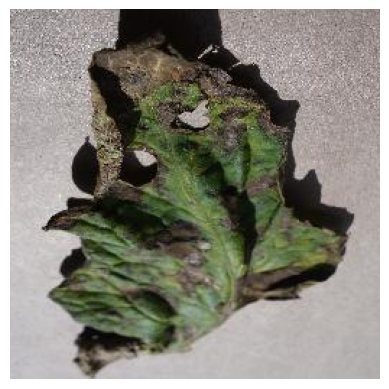

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
import os

root = "plantvillage dataset/color"
class_name = os.listdir(root)[0]
img_path = os.path.join(root, class_name, os.listdir(os.path.join(root, class_name))[0])

img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")


In [23]:
import os

DATASET_DIR = "plantvillage dataset/color"

print("Number of classes:", len(os.listdir(DATASET_DIR)))
print("Sample classes:", os.listdir(DATASET_DIR)[:5])


Number of classes: 38
Sample classes: ['Tomato___Early_blight', 'Apple___Cedar_apple_rust', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)']


In [24]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.30,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 54305 files belonging to 38 classes.
Using 38014 files for training.
Found 54305 files belonging to 38 classes.
Using 16291 files for validation.


In [25]:
val_size = int(0.5 * temp_ds.cardinality().numpy())

val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

print("Train batches:", train_ds.cardinality().numpy())
print("Validation batches:", val_ds.cardinality().numpy())
print("Test batches:", test_ds.cardinality().numpy())


Train batches: 1188
Validation batches: 255
Test batches: 255


In [28]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [29]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [30]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)


In [32]:
AUTOTUNE = tf.data.AUTOTUNE

augmented_train_ds = augmented_train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


In [37]:
for images, labels in train_ds.take(1):
    print("dtype:", images.dtype)
    print("min value:", tf.reduce_min(images).numpy())
    print("max value:", tf.reduce_max(images).numpy())


dtype: <dtype: 'float32'>
min value: 0.0
max value: 0.003921569


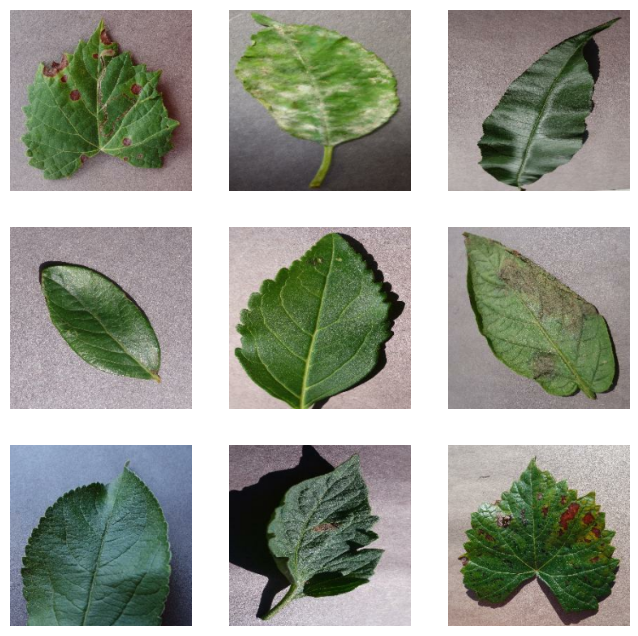

In [44]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(8, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        img = images[i].numpy()
        img = img * 255.0 * 255.0
        img = img.astype("uint8")

        plt.imshow(img)
        plt.axis("off")
    plt.show()
